# EE837B Advances in Convolutional Neural Networks (Fall 2023)
## Programming Assignment
Department of Electrical Engineering, KAIST

- Course Instructor : Prof. Junmo Kim

- Primary TA : Hyounguk Shon

- For questions regarding this assignment, use the course Q&A board on KLMS.

---

In this programming assignment, you are asked to reproduce the [Knowledge Distillation (KD) algorithm](https://arxiv.org/abs/1503.02531) in PyTorch. Your python code should distill a pre-trained teacher model into a smaller student model using the CIFAR-100 dataset. Additionally, we have an optional challenge for bonus credits.

In [ ]:
import os
import random

import gdown
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms


# set random seed for reproducibility
torch.manual_seed(1234)
random.seed(1234)
np.random.seed(1234)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# cd /content/drive/MyDrive/Advanced\ CNN/For\ submission

/content/drive/MyDrive/Advanced CNN/For submission


# Define ResNet architecture
Do not change this code block

In [ ]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False
    )

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, is_last=False):
        super(BasicBlock, self).__init__()
        self.is_last = is_last
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        preact = out
        out = F.relu(out)
        if self.is_last:
            return out, preact
        else:
            return out

class ResNet(nn.Module):
    def __init__(self, depth, num_filters, block_name="BasicBlock", num_classes=100):
        super(ResNet, self).__init__()
        assert (
            depth - 2
        ) % 6 == 0, "When use basicblock, depth should be 6n+2, e.g. 20, 32, 44, 56, 110, 1202"
        n = (depth - 2) // 6
        block = BasicBlock

        self.inplanes = num_filters[0]
        self.conv1 = nn.Conv2d(3, num_filters[0], kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_filters[0])
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, num_filters[1], n)
        self.layer2 = self._make_layer(block, num_filters[2], n, stride=2)
        self.layer3 = self._make_layer(block, num_filters[3], n, stride=2)
        self.avgpool = nn.AvgPool2d(8)
        self.fc = nn.Linear(num_filters[3] * block.expansion, num_classes)
        self.stage_channels = num_filters

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(
                    self.inplanes,
                    planes * block.expansion,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = list([])
        layers.append(
            block(self.inplanes, planes, stride, downsample, is_last=(blocks == 1))
        )
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, is_last=(i == blocks - 1)))

        return nn.Sequential(*layers)

    def get_feat_modules(self):
        feat_m = nn.ModuleList([])
        feat_m.append(self.conv1)
        feat_m.append(self.bn1)
        feat_m.append(self.relu)
        feat_m.append(self.layer1)
        feat_m.append(self.layer2)
        feat_m.append(self.layer3)
        return feat_m

    def get_bn_before_relu(self):
        bn1 = self.layer1[-1].bn2
        bn2 = self.layer2[-1].bn2
        bn3 = self.layer3[-1].bn2
        return [bn1, bn2, bn3]

    def get_stage_channels(self):
        return self.stage_channels

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)  # 32x32
        f0 = x

        x, f1_pre = self.layer1(x)  # 32x32
        f1 = x
        x, f2_pre = self.layer2(x)  # 16x16
        f2 = x
        x, f3_pre = self.layer3(x)  # 8x8
        f3 = x

        x = self.avgpool(x)
        avg = x.reshape(x.size(0), -1)
        out = self.fc(avg)

        return out

def resnet8x4(**kwargs):
    return ResNet(8, [32, 64, 128, 256], "basicblock", **kwargs)

def resnet32x4(**kwargs):
    return ResNet(32, [32, 64, 128, 256], "basicblock", **kwargs)

# Define Base Trainer Class
Do not change this code block.

The base trainer will automatically download and load pre-trained teacher weights.

In [ ]:
class BaseTrainer:
    pretrained_teacher_link = 'https://drive.google.com/uc?id=1Gh3Z8BZ62PGD7PQiFiwmU9vMwMpF5F46'

    def __init__(self):
        self.teacher = resnet32x4(num_classes=100)
        self.student = resnet8x4(num_classes=100)
        gdown.download(self.pretrained_teacher_link, './resnet_32x4.pth', resume=True)
        self.teacher.load_state_dict(torch.load("./resnet_32x4.pth", map_location="cpu")["model"])

        self.train_transform = transforms.Compose([
                transforms.RandomCrop(32, padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
                ])
        self.test_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
                ])

        self.train_set = datasets.CIFAR100('./data/', download=True, train=True, transform=self.train_transform)
        self.test_set = datasets.CIFAR100('./data/', download=False, train=False, transform=self.test_transform)
        self.test_dataloader = DataLoader(self.test_set, batch_size=64, shuffle=False)

    def save_student_checkpoint(self, ckpt_path):
        state_dict = self.student.state_dict()
        torch.save(state_dict, ckpt_path)

    def load_student_checkpoint(self, ckpt_path):
        state_dict = torch.load(ckpt_path, map_location="cpu")
        self.student.load_state_dict(state_dict)

    @torch.no_grad()
    def evaluate_student(self):
        self.student.cuda().eval()
        n = 0
        correct = 0
        for image, target in self.test_dataloader:
            image = image.cuda()
            target = target.cuda()
            output = self.student(image)
            n += image.size(0)
            correct += output.max(-1).indices.eq(target).sum().item()
        accuracy = 100 * correct / n
        return accuracy

    def train_student(self):
        pass

# Training algorithm implementation

In this section, you need to implement training of the student model.
Specifically, you need to implement the followings:

1. Knowledge Distillation algorithm
2. Training pipeline

You are free to edit below skeleton code. You are not allowed to edit the model architecture and data augmentation method.

In [ ]:
### IMPLEMENT THIS TRAINER CLASS ###

from torch.utils.data import Subset
import matplotlib.pyplot as plt

class KDTrainer(BaseTrainer):
    def __init__(self, temp=43.25, lamb=38.21, wd=1e-4, lr=0.001):
        super().__init__()
        ### YOU MAY EDIT BELOW ###

        num_train = 49984
        self.train_dataloader = DataLoader(self.train_set, batch_size=64, shuffle=True, num_workers=2, drop_last=True) # 49984/64=781
        self.mid_epoch = 180
        self.max_epoch = 200
        self.optimizer = optim.Adam(self.student.parameters(), lr=lr, betas=(0.9,0.999), weight_decay = wd)
        self.ce = nn.CrossEntropyLoss()
        self.kl = nn.KLDivLoss(reduction='batchmean')
        self.temp = temp
        self.lamb = lamb
        self.wd = wd
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        ### The loss will be KL(p_s,p_ground) + \lambda KL(q_s,q_t) * T^2

    def train_student(self, start_epoch=0, end_epoch=None, print_result = True):
        #### IMPLEMENT TRAINING HERE ####
        loss_hist = []
        train_acc_hist = []
        test_acc_hist = []

        self.teacher.cuda().eval()
        self.student.cuda().train()
        tdl = self.train_dataloader

        if end_epoch == None:
            end_epoch = self.max_epoch
        for epoch in range(start_epoch, self.mid_epoch):
            self.student.cuda().train()
            correct = 0
            total = 0
            epoch_mean_loss = []
            if print_result:
                print(f"Epoch {epoch}")
            for batch_idx, (train_data, train_label) in enumerate(tdl):
                train_data, train_label = train_data.to(self.device), train_label.to(self.device)# on GPU

                self.optimizer.zero_grad()
                soft_teacher_output = self.teacher(train_data)/self.temp
                student_output = self.student(train_data)
                soft_student_output = student_output/self.temp

                pred = torch.max(student_output, dim=1)

                loss = self.lamb * self.kl(F.log_softmax(soft_student_output,dim=1), F.softmax(soft_teacher_output,dim=1)) * (self.temp**2)
                loss += self.ce(student_output, train_label)
                epoch_mean_loss.append(loss.item())
                loss.backward()
                self.optimizer.step()

                correct += student_output.max(-1).indices.eq(train_label).sum().item()
                total += train_label.size(0)
                if print_result:
                    if (batch_idx+1)%200==0 or batch_idx == 780:
                        print(f"Acc: {correct}/{total} " + f"Loss: {loss.item()}")
            train_acc = correct/total*100
            loss_hist.append(sum(epoch_mean_loss)/len(epoch_mean_loss))
            train_acc_hist.append(train_acc)
            if print_result:
                print(f"Train accuracy: {train_acc:.4f}%")
            test_acc = self.evaluate_student()
            test_acc_hist.append(test_acc)
            if print_result:
                print(f"Test accuracy: {test_acc:.4f}%")

        lr = 1e-4
        self.optimizer = optim.Adam(self.student.parameters(), lr=lr, betas=(0.9,0.999), weight_decay = self.wd)
        for epoch in range(self.mid_epoch,self.max_epoch):
            self.student.cuda().train()
            correct = 0
            total = 0
            epoch_mean_loss = []
            if print_result:
                print(f"Epoch {epoch}")
            for batch_idx, (train_data, train_label) in enumerate(tdl):
                train_data, train_label = train_data.to(self.device), train_label.to(self.device)# on GPU

                self.optimizer.zero_grad()
                soft_teacher_output = self.teacher(train_data)/self.temp
                student_output = self.student(train_data)
                soft_student_output = student_output/self.temp

                pred = torch.max(student_output, dim=1)

                loss = self.lamb * self.kl(F.log_softmax(soft_student_output,dim=1), F.softmax(soft_teacher_output,dim=1)) * (self.temp**2)
                loss += self.ce(student_output, train_label)
                epoch_mean_loss.append(loss.item())
                loss.backward()
                self.optimizer.step()
                correct += student_output.max(-1).indices.eq(train_label).sum().item()
                total += train_label.size(0)
                if print_result:
                    if (batch_idx+1)%200==0 or batch_idx == 780:
                        print(f"Acc: {correct}/{total} " + f"Loss: {loss.item()}")
            train_acc = correct/total*100
            loss_hist.append(sum(epoch_mean_loss)/len(epoch_mean_loss))
            train_acc_hist.append(train_acc)
            if print_result:
                print(f"Train accuracy: {train_acc:.4f}%")
            test_acc = self.evaluate_student()
            test_acc_hist.append(test_acc)
            if print_result:
                print(f"Test accuracy: {test_acc:.4f}%")
        #### Plot
        plt.clf()
        epoches = list(range(1,self.max_epoch+1))
        plt.plot(epoches,train_acc_hist)
        plt.plot(epoches,test_acc_hist)
        plt.xlabel('epoch')
        plt.ylabel('Accuracy')
        plt.legend(('train_acc','test_acc'))
        plt.savefig('./acc.png', dpi=300)

        plt.clf()
        plt.plot(epoches,loss_hist)
        plt.xlabel('epoch')
        plt.ylabel('Loss')
        plt.savefig('./loss.png', dpi=300)

    def save_ckpt(self,epoch):
        state_dict = self.student.state_dict()
        opt_dict = self.optimizer.state_dict()
        torch.save({'model_state_dict':state_dict,
                    'opt_state_dict':opt_dict}, self.PATHPATH + f"Epoch{epoch}.ckpt")
    def load_ckpt(self,epoch):
        ckpt = torch.load(self.PATHPATH+f"Epoch{epoch}.ckpt")
        self.student.load_state_dict(ckpt['model_state_dict'])
        # self.student.cuda().eval()
        self.optimizer.load_state_dict(ckpt['opt_state_dict'])
        for state in self.optimizer.state.values():
            for k,v in state.items():
                if torch.is_tensor(v):
                    state[k]=v.to(self.device)

        # weight_decay



In [ ]:
import matplotlib.pyplot as plt
import random
import math
import os

def sample_hyp_params():
  temp = 10**random.uniform(np.log10(20),np.log10(80))
  lamb = (10**random.uniform(np.log10(10),np.log10(80)))
  temp = round(temp,2)
  lamb = round(lamb,2)
  # temp = 43.25
  # lamb = 38.21
  print("Temp: ",temp, " Lambda: ",lamb)
  return temp, lamb

def train_student(temp,lamb,lr,wd,start_epoch=0,end_epoch=100):
    PATHPATH = PATH+f"T{temp:.2f}L{lamb:.2f}W{wd:.4f}"
    if start_epoch == 0:
        os.mkdir(PATHPATH)
    kd = KDTrainer(temp=temp,lamb=lamb,wd=wd,lr=lr)
    train_acc_hist, test_acc_hist = kd.train_student(start_epoch=start_epoch, end_epoch=end_epoch, print_result=True)
    return train_acc_hist, test_acc_hist

def hyp_param_search(N,wd=1e-4,lr=0.001,end_epoch=30):
  for i in range(N):
    # res = torch.load(PATH+'result.pt')
    temp, lamb = sample_hyp_params()
    PATHPATH = PATH+f"T{temp:.2f}L{lamb:.2f}W{wd:.4f}"
    while os.path.isdir(PATHPATH):
      temp, lamb = sample_hyp_params()
      PATHPATH = PATH+f"T{temp:.2f}L{lamb:.2f}W{wd:.4f}"

    train_acc_hist, test_acc_hist = train_student(temp=temp,lamb=lamb,lr=lr,wd=wd,start_epoch=0,end_epoch=end_epoch)

    print(f"Train:{train_acc_hist[-1]}, Test:{test_acc_hist[-1]}")
    # res.append([temp,lamb,train_acc_hist[-1],test_acc_hist[-1]])
    # torch.save(res, PATH+'result.pt')


In [ ]:
# hyp_param_search(30,lr=1e-3)
# train_student(temp=43.25,lamb=38.21,lr=1e-4,wd=1e-4,start_epoch=180,end_epoch=400)

In [ ]:
# import matplotlib.pyplot as plt
# from matplotlib  import cm
# import matplotlib as mpl

# res = torch.load(PATH+"result.pt")

# fig = plt.figure(figsize=(6,6))

# ax = fig.add_subplot(111)
# ax.set_title("Test Accuracy",fontsize=14)
# ax.set_xlabel("T",fontsize=12)
# ax.set_xscale('log')
# ax.set_ylabel("$\lambda$",fontsize=12)
# ax.set_yscale('log')

# ax.grid(True,linestyle='-',color='0.75')
# x = [re[0] for re in res]
# y = [re[1] for re in res]
# z = [re[3] for re in res]
# # scatter with colormap mapping to z value
# norm = mpl.colors.Normalize(vmin=60, vmax=70)
# ax.scatter(x,y,s=20,c=z, marker = 'o', cmap = cm.jet, norm=norm)
# mapping = cm.ScalarMappable(norm=norm,cmap=cm.jet)
# fig.colorbar(mappable=mapping)
# plt.show()

In [ ]:
# res = torch.load(PATH+"result.pt")
# maxT=0
# maxL=0
# maxAcc = 0
# for re in res:
#   if re[3] >maxAcc:
#     maxT=re[0]
#     maxL=re[1]
#     maxAcc=re[3]

# print(maxT,maxL,maxAcc)

# Training and Evaluation

You do not need to modify the code in this section except the checkpoint path (**CKPT_PATH**).

TAs will reproduce the results of your report with submitted checkpoint.

**Before submission, make sure to check that the following code can print evaluation on your student model.**

Downloading...
From: https://drive.google.com/uc?id=1Gh3Z8BZ62PGD7PQiFiwmU9vMwMpF5F46
To: /content/drive/MyDrive/Advanced CNN/For submission/resnet_32x4.pth
100%|██████████| 59.6M/59.6M [00:00<00:00, 226MB/s]


100%|██████████| 169001437/169001437 [00:18<00:00, 9210396.58it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data/
Epoch 0
Acc: 1014/12800 Loss: 83.90213775634766
Acc: 2928/25600 Loss: 78.42284393310547
Acc: 5444/38400 Loss: 80.26675415039062
Acc: 8087/49984 Loss: 75.66827392578125
Train accuracy: 16.1792%
Test accuracy: 22.8400%
Epoch 1
Acc: 3332/12800 Loss: 76.1744155883789
Acc: 6942/25600 Loss: 64.49232482910156
Acc: 10843/38400 Loss: 73.93506622314453
Acc: 14722/49984 Loss: 71.06636810302734
Train accuracy: 29.4534%
Test accuracy: 32.6700%
Epoch 2
Acc: 4567/12800 Loss: 66.38475799560547
Acc: 9329/25600 Loss: 61.21508026123047
Acc: 14247/38400 Loss: 63.22962951660156
Acc: 18832/49984 Loss: 63.32634735107422
Train accuracy: 37.6761%
Test accuracy: 38.0000%
Epoch 3
Acc: 5425/12800 Loss: 60.434181213378906
Acc: 11027/25600 Loss: 66.92382049560547
Acc: 16683/38400 Loss: 57.52893829345703
Acc: 21929/49984 Loss: 61.339256286621094
Train accuracy: 43.8720%
Test accuracy: 40.8200%
Epoch 4
Acc: 6042/12800 Loss: 57.964996337890625
Acc: 12153/25600 Loss:

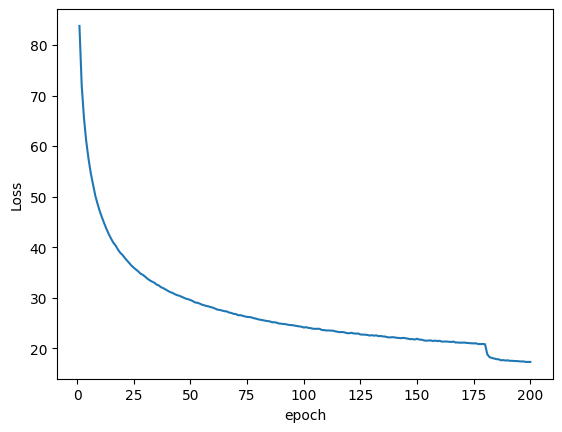

In [ ]:
CKPT_PATH = "./student_checkpoint.pth"

trainer = KDTrainer()
trainer.train_student()
trainer.save_student_checkpoint(CKPT_PATH)

In [ ]:
trainer.load_student_checkpoint(CKPT_PATH)
accuracy = trainer.evaluate_student()

print(f"Student model test accuracy: {accuracy:.3f} %")
print(f"Is above threshold performance? {accuracy > 72.2}")

Student model test accuracy: 73.380 %
Is above threshold performance? True


# Improved KD algorithm implementation (optional)

This section is optional -- you can decide to leave this section untouched.

Here, you can implement a more advanced KD algorithm of your choice.
We will give bonus credits depending on the performance of your KD algorithm.

You are not allowed to edit the model architecture and data augmentation method. If you need to access the hidden layer features, refer to [nn.Module hooks](https://pytorch.org/docs/stable/generated/torch.nn.Module.html?highlight=forward_hook#torch.nn.Module.register_forward_hook).

In [ ]:
### IMPLEMENT THIS TRAINER CLASS ###

class ImprovedKDTrainer(BaseTrainer):
    def __init__(self):
        super().__init__()
        ### YOU MAY EDIT BELOW ###
        self.train_dataloader = DataLoader(self.train_set, batch_size=64, shuffle=True, num_workers=2, drop_last=True)

        self.init_lr = 0.1
        self.max_epoch = 200
        self.optimizer = optim.SGD(self.student.parameters(), lr=self.init_lr, momentum=0.9, weight_decay=1e-4)
        ...

    def train_student(self):
        #### IMPLEMENT TRAINING HERE ####
        self.teacher.cuda().eval()
        self.student.cuda().train()
        for epoch in range(self.max_epoch):
            ...

In [ ]:
!pwd

/content


In [ ]:
CKPT_PATH = "./student_improved_checkpoint.pth"

trainer = ImprovedKDTrainer()
trainer.train_student()
trainer.save_student_checkpoint(CKPT_PATH)

In [ ]:
trainer.load_student_checkpoint(CKPT_PATH)
accuracy = trainer.evaluate_student()

print(f"Improved student model test accuracy: {accuracy:.3f} %")